In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define constants
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 0.001
EPOCHS = 10

In [3]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
train_path="data/Train"
test_path="data/Test"
val_path="data/Validation"

In [5]:
train_datagen = ImageDataGenerator( rescale=1./255) 
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMG_SIZE ,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle=False)
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


In [6]:
# Load pre-trained InceptionResNetV2 model without classification layers
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
    
# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
train_model = model.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set)
)

Epoch 1/10
4376/4376 [==============================] - 3119s 704ms/step - loss: 0.5330 - accuracy: 0.7306 - val_loss: 0.4940 - val_accuracy: 0.7676
Epoch 2/10
4376/4376 [==============================] - 2131s 487ms/step - loss: 0.4925 - accuracy: 0.7557 - val_loss: 0.4847 - val_accuracy: 0.7803
Epoch 3/10
4376/4376 [==============================] - 2393s 547ms/step - loss: 0.4836 - accuracy: 0.7603 - val_loss: 0.4941 - val_accuracy: 0.7835
Epoch 4/10
4376/4376 [==============================] - 3604s 824ms/step - loss: 0.4739 - accuracy: 0.7658 - val_loss: 0.4968 - val_accuracy: 0.7826
Epoch 5/10
4376/4376 [==============================] - 2295s 524ms/step - loss: 0.4655 - accuracy: 0.7716 - val_loss: 0.4797 - val_accuracy: 0.7888
Epoch 6/10
4376/4376 [==============================] - 2113s 483ms/step - loss: 0.4605 - accuracy: 0.7726 - val_loss: 0.4944 - val_accuracy: 0.7865
Epoch 7/10
4376/4376 [==============================] - 2110s 482ms/step - loss: 0.4543 - accuracy: 0.7772

In [10]:
# Save the model
model.save('deepfake_detection_model2.h5')

In [11]:
test_steps = len(test_set)
test_loss, test_accuracy = model.evaluate(test_set, steps=test_steps)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

341/341 [==============================] - 130s 381ms/step - loss: 0.5470 - accuracy: 0.7255
Test Loss: 0.5470232367515564
Test Accuracy: 0.7255387306213379


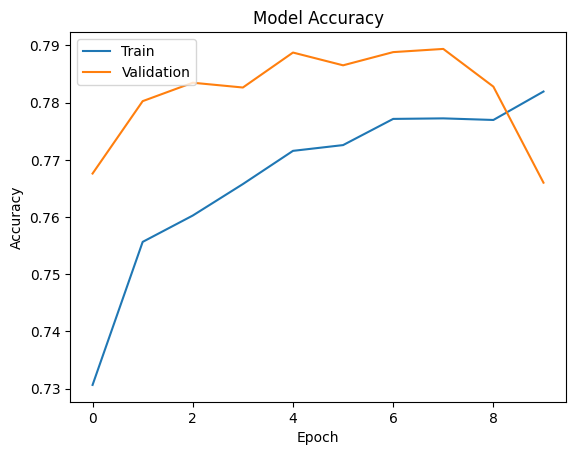

In [12]:
# Plot training & validation accuracy values
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

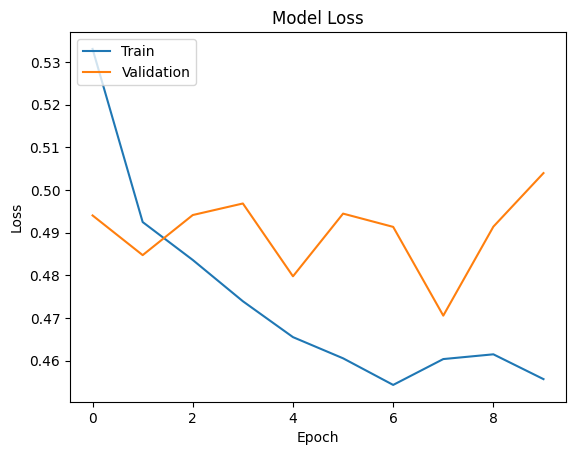

In [13]:
# Plot training & validation loss values
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Predict probabilities for test images
y_test = test_set.classes
y_pred_prob = model.predict(test_set, steps=test_steps)

In [15]:
# Predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

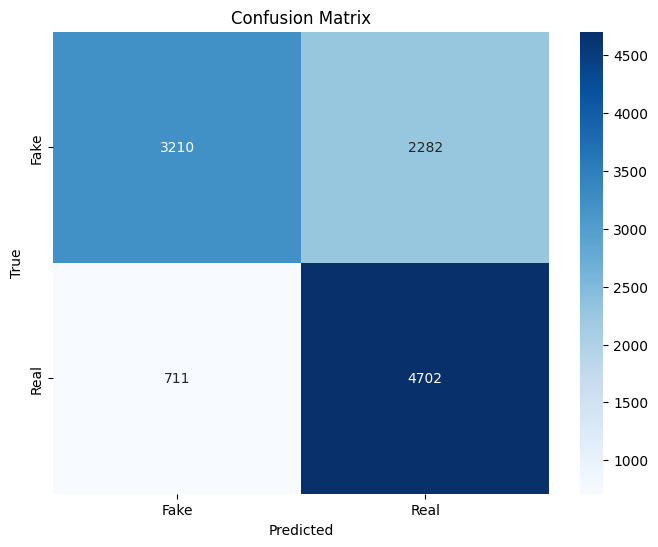

In [16]:
# Plot confusion matrix as a heatmap
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Classification report
class_labels = list(test_set.class_indices.keys())
class_report = classification_report(y_test, y_pred, target_names=class_labels)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        Fake       0.82      0.58      0.68      5492
        Real       0.67      0.87      0.76      5413

    accuracy                           0.73     10905
   macro avg       0.75      0.73      0.72     10905
weighted avg       0.75      0.73      0.72     10905



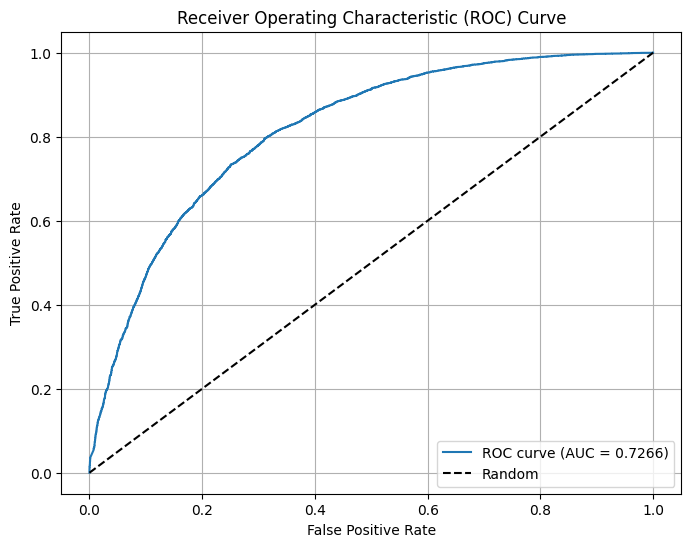

In [18]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

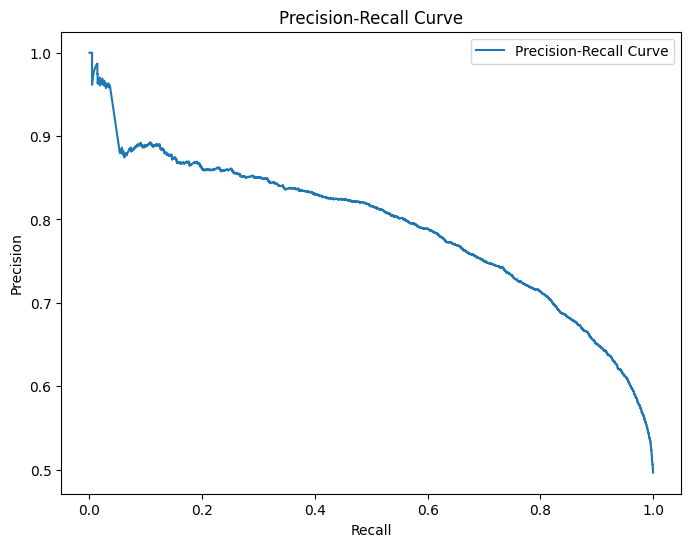

In [19]:
# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob[:, 1])

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [21]:
# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')

Sensitivity (True Positive Rate): 0.8686
Specificity (True Negative Rate): 0.5845


In [22]:
# Calculate F1 score for the test classes
f1 = f1_score(y_test, y_pred)
# Calculate accuracy to get error rate
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
# Calculate G-mean
g_mean = (sensitivity * specificity) ** 0.5

# Calculate F-measure
f_measure = 2 * ((sensitivity * specificity) / (sensitivity + specificity))

print(f'F1 Score: {f1:.4f}')
print(f'Error Rate: {error_rate:.4f}')
print(f'G-mean: {g_mean:.4f}')
print(f'F-measure: {f_measure:.4f}')

F1 Score: 0.7586
Error Rate: 0.2745
G-mean: 0.7125
F-measure: 0.6988


In [ ]:
# Testing with random images
def predict_image(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.

    prediction = model.predict(img_array)
    if prediction[0][0] > prediction[0][1]:
        return "Deepfake Image"
    else:
        return "Real Image"

test_image_paths = ["2.jpg", "1.jpg", "3.jpg", "4.jpg"] # List of paths to random test images

for image_path in test_image_paths:
    prediction = predict_image(model, image_path)
    print(f"Prediction for {image_path}: {prediction}")